In [2]:
from selenium.webdriver import Chrome, ChromeOptions
options = ChromeOptions()
options.add_argument('--headless')

web_driver = Chrome(executable_path='C:/Users/srijith/Downloads/chromedriver_win32/chromedriver.exe', options = options)

C:\Users\srijith\AppData\Local\Temp/ipykernel_3056/1530440681.py:5: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  web_driver = Chrome(executable_path='C:/Users/srijith/Downloads/chromedriver_win32/chromedriver.exe', options = options)


In [2]:

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output

import os
import pandas as pd
from pathlib import Path
from sklearn import metrics
import statistics
import copy
import geopandas as gpd
import numpy as np

import seaborn as sns 
import infrarisk.src.network_sim_models.interdependencies as interdependencies
from infrarisk.src.network_sim_models.integrated_network import *

In [3]:

network_dir = Path('../../data/networks/micropolis')
water_folder = network_dir/'water/med'
power_folder = network_dir/'power/low'
transpo_folder = network_dir/'transportation/high'

micropolis_network = IntegratedNetwork(name = 'Micropolis', 
                                       water_folder= water_folder,
                                       power_folder = power_folder,
                                       transp_folder=transpo_folder,
                                       water_sim_type = 'PDA',
                                       power_sim_type='1ph')

Water network successfully loaded from ..\..\data\networks\micropolis\water\med/water.inp. The analysis type is set to PDA.
initial simulation duration: 60s; hydraulic time step: 60s; pattern time step: 3600s

Power system successfully loaded from ..\..\data\networks\micropolis\power\low\power.json. Single phase power flow simulation will be used.

Transportation network successfully loaded from ..\..\data\networks\micropolis\transportation\high. Static traffic assignment method will be used to calculate travel times.


In [5]:
micropolis_network.generate_integrated_graph()

Successfully added power network to the integrated graph...
Successfully added water network to the integrated graph...
Successfully added transportation network to the integrated graph...
Integrated graph successffully created.
Generating betweenness centrality...


Loading BokehJS ...

In [6]:

folder = 'E:/dreaminsg data'
#folder = Path('../../data/networks/micropolis/scenarios')
scenarios = [f for f in sorted(os.listdir(folder)) if f.startswith('flood')]

In [7]:
direct_impact_dict = {}

for index, scenario in enumerate(scenarios):
    disruption_file = pd.read_csv(f"{folder}/{scenario}/disruption_file.csv")
    
    for compon in disruption_file.components.unique():
        if compon in direct_impact_dict.keys():
            direct_impact_dict[compon] += 1
        else:
            direct_impact_dict[compon] = 1

for compon in direct_impact_dict.keys():
    direct_impact_dict[compon] = direct_impact_dict[compon]/len(scenarios)

In [8]:
G = micropolis_network.integrated_graph

In [9]:
for node in G.nodes.keys():
    if node in direct_impact_dict.keys():
        G.nodes[node]["fail_prob"] = direct_impact_dict[node]
    else:
        G.nodes[node]["fail_prob"] = 0
    
for link in G.edges.keys():
    link_id = G.edges[link]["id"]
    if link_id in direct_impact_dict.keys():
        G.edges[link]["fail_prob"] = direct_impact_dict[link_id]
    else:
        G.edges[link]["fail_prob"] = 0

In [10]:
from bokeh.plotting import figure
from bokeh.transform import factor_cmap, linear_cmap
import bokeh.palettes as palettes
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource, HoverTool,  ColorBar
from bokeh.tile_providers import get_provider, Vendors
from bokeh.layouts import gridplot

# Component failure probabilities due to floods

In [11]:
palette =  tuple(["#32CD32", "#76D021", "#BAD310", "#FFD700", "#FF8F00", "#FF4700", "#FF0000"])

p = figure(
    background_fill_color="white",
    plot_width=800,
    height=500,
    #title=f"Component failure probability due to Micropolis floods",
    x_range=(1000, 8000),
    y_range=(1200, 6800),
)

# instatiate the tile source provider
#tile_provider = get_provider(Vendors.CARTODBPOSITRON_RETINA)

# add the back ground basemap
#p.add_tile(tile_provider, alpha=0.1)

# event area
micropolis_streams = gpd.read_file(network_dir / "gis/streams_v1.shp", encoding="utf-8")
micropolis_streams = list(micropolis_streams.loc[[1, 2], 'geometry'])
for _, track in enumerate(micropolis_streams):
    track_buffer = track.buffer(150)

    x, y = [], []
    [
        (
            x.append(list(track_buffer.exterior.coords.xy[0])),
            y.append(list(track_buffer.exterior.coords.xy[1])),
        )
    ]

    p.patches(
            "x",
            "y",
            source=ColumnDataSource(dict(x=x, y=y)),
            fill_color="lightblue",
            fill_alpha=0.5,
            line_color="lightblue",
            line_alpha=0.75,
            legend_label="Floodplains",
        )


# links
x, y, link_layer, link_category, fail_prob, id = [], [], [], [], [], []
for _, link in enumerate(G.edges.keys()):
    x.append([G.nodes[link[0]]["coord"][0], G.nodes[link[1]]["coord"][0]])
    y.append([G.nodes[link[0]]["coord"][1], G.nodes[link[1]]["coord"][1]])
    link_layer.append(G.edges[link]["link_type"])
    link_category.append(G.edges[link]["link_category"])
    fail_prob.append(G.edges[link]["fail_prob"])
    id.append(G.edges[link]["id"])
    
    

color_mapper = linear_cmap(field_name = "fail_prob", palette = palette, low = 0, high = 0.35, nan_color = 'black')

plot_links = p.multi_line(
    "x",
    "y",
    source=ColumnDataSource(
        dict( x=x, y=y, link_layer=link_layer, link_category=link_category, fail_prob=fail_prob, id=id)
    ),
    line_color=color_mapper, line_alpha=1, line_width=2.5, 
    #legend_field="fail_prob",
)
p.legend.label_text_font_size = '14pt'

color_bar = ColorBar(color_mapper=color_mapper['transform'], width=20,  location=(0,0),title="Mean probability of component failure",
                    title_text_font = 'helvetica', title_text_font_style = 'normal', title_text_font_size = '14pt',
                    major_label_text_font_size = '14pt')
p.add_layout(color_bar, 'right')

p.legend.location = "bottom_left"
p.axis.visible = False
p.grid.visible = False
p.outline_line_color = None
show(p)

from bokeh.io import export_png
export_png(p, filename = f"plots/direct_impact.png", webdriver=web_driver)

'e:\\dreaminsg_integrated_model\\infrarisk\\experiments\\infrarisk_case_study\\plots\\direct_impact.png'

In [12]:
avg_water_demand_ratio = {'capacity': {}, 'centrality': {}, 'zone': {}}
avg_power_demand_ratio = {'capacity': {}, 'centrality': {}, 'zone': {}}

In [13]:

for index, scenario in enumerate(scenarios):
    print(index,"/",len(scenarios), scenario)
    for strategy in ['capacity', 'zone', 'centrality']:
        if os.path.isfile(f"{folder}/{scenario}/{strategy}/water_demands_ratio.csv"):
            water_demands_ratio = pd.read_csv(f"{folder}/{scenario}/{strategy}/water_demands_ratio.csv", sep = ",")
            power_demands_ratio = pd.read_csv(f"{folder}/{scenario}/{strategy}/power_demand_ratio.csv", sep = ",")
            water_auc = pd.read_csv(f"{folder}/{scenario}/{strategy}/water_auc.csv", sep = ",")
            power_auc = pd.read_csv(f"{folder}/{scenario}/{strategy}/power_auc.csv", sep = ",")
            for column in water_demands_ratio.columns:
                if column.startswith("W_JTN"):
                    if column in avg_water_demand_ratio[strategy].keys():
                        avg_water_demand_ratio[strategy][column].append(metrics.auc(water_auc.time, 1 - water_demands_ratio[column]))
                    else:
                        avg_water_demand_ratio[strategy][column] = [metrics.auc(water_auc.time, 1 - water_demands_ratio[column])]
            for column in power_demands_ratio.columns:
                if column in avg_power_demand_ratio[strategy].keys():
                    avg_power_demand_ratio[strategy][column].append(metrics.auc(power_auc.time, 1 - power_demands_ratio[column]))
                else:
                    avg_power_demand_ratio[strategy][column] = [metrics.auc(power_auc.time, 1 - power_demands_ratio[column])]
    clear_output(wait=True)

163 / 164 flood99


In [14]:
water_compon_auc = {'capacity': {}, 'centrality': {}, 'zone': {}}
power_compon_auc = {'capacity': {}, 'centrality': {}, 'zone': {}}
for strategy in ['capacity', 'zone', 'centrality']:
    for node in avg_water_demand_ratio[strategy].keys():
        water_compon_auc[strategy][node] = statistics.mean(avg_water_demand_ratio[strategy][node])/60
    for node in avg_power_demand_ratio[strategy].keys():
        power_compon_auc[strategy][node] = statistics.mean(avg_power_demand_ratio[strategy][node])/60


In [15]:
water_compon_auc_df = pd.DataFrame(water_compon_auc)
water_compon_auc_df["component"] = water_compon_auc_df.index

power_compon_auc_df = pd.DataFrame(power_compon_auc)
power_compon_auc_df["component"] = power_compon_auc_df.index

# water_compon_auc_df.to_csv(f"{folder}/{scenario}/{strategy}/water_compon_auc.csv", sep = ",", index = False)
# power_compon_auc_df.to_csv(f"{folder}/{scenario}/{strategy}/power_compon_auc.csv", sep = ",", index = False)

# Consumer-level water outage

In [18]:

#strategy = 'zone'
auc_type = water_compon_auc
water_plots = {}
for i, strategy in enumerate(['capacity', 'zone', 'centrality']):
    print(strategy)
    for node in G.nodes.keys():
        if node in auc_type[strategy].keys():
            G.nodes[node]["avg_perf"] = auc_type[strategy][node]
        else:
            G.nodes[node]["avg_perf"] = np.nan
        
    for link in G.edges.keys():
        link_id = G.edges[link]["id"]
        if link_id in auc_type[strategy].keys():
            G.edges[link]["avg_perf"] = auc_type[strategy][link_id]
        else:
            G.edges[link]["avg_perf"] = np.nan
            

    palette = tuple( ["#32CD32", "#5FCF26", "#8DD11B", "#BAD310", "#E8D505", "#FFBF00", "#FF8F00", "#FF5F00", "#FF2F00", "#FF0000"])

    if i != 2:
        p = figure(
            background_fill_color="white",
            plot_width=700,
            height=500,
            #title=f"Mean consumer-level outage during floods: {strategy}-based recovery strategy",
            x_range=(1400, 7400),
            y_range=(2000, 6000),
        )
    else:
        p = figure(
            background_fill_color="white",
            plot_width=785,
            height=500,
            #title=f"Mean consumer-level outage during floods: {strategy}-based recovery strategy",
            x_range=(1400, 7400),
            y_range=(2000, 6000),
        )

    # instatiate the tile source provider
    #tile_provider = get_provider(Vendors.CARTODBPOSITRON_RETINA)

    # add the back ground basemap
    #p.add_tile(tile_provider, alpha=0.1)

    # event area
    micropolis_streams = gpd.read_file(network_dir / "gis/streams_v1.shp", encoding="utf-8")
    micropolis_streams = list(micropolis_streams.loc[[1, 2], 'geometry'])
    for _, track in enumerate(micropolis_streams):
        track_buffer = track.buffer(150)

        x, y = [], []
        [
            (
                x.append(list(track_buffer.exterior.coords.xy[0])),
                y.append(list(track_buffer.exterior.coords.xy[1])),
            )
        ]

        p.patches(
            "x",
            "y",
            source=ColumnDataSource(dict(x=x, y=y)),
            fill_color="lightblue",
            fill_alpha=0.5,
            line_color="lightblue",
            line_alpha=0.75,
            legend_label="Floodplains",
        )

    # links
    x, y, link_layer, link_category, avg_perf, id = [], [], [], [], [], []
    for _, link in enumerate(G.edges.keys()):
        x.append([G.nodes[link[0]]["coord"][0], G.nodes[link[1]]["coord"][0]])
        y.append([G.nodes[link[0]]["coord"][1], G.nodes[link[1]]["coord"][1]])
        link_layer.append(G.edges[link]["link_type"])
        link_category.append(G.edges[link]["link_category"])
        avg_perf.append(G.edges[link]["avg_perf"])
        id.append(G.edges[link]["id"])
        
        

    #color_mapper = linear_cmap(field_name = "avg_perf", palette = palette, low = 0, high = np.nanmax(avg_perf), nan_color = 'snow')

    plot_links = p.multi_line(
        "x",
        "y",
        source=ColumnDataSource(
            dict( x=x, y=y, link_layer=link_layer, link_category=link_category, avg_perf=avg_perf, id=id)
        ),
        line_color='grey', line_alpha=0.5, line_width=0.75, 
        legend_label="Infrastructure links",
        #legend_field="fail_prob",
    )

    x, y, node_type, node_category, avg_perf, id = [], [], [], [], [], []

    for _, node in enumerate(G.nodes.keys()):
        if G.nodes[node]["avg_perf"] is not np.nan:
            x.append(G.nodes[node]["coord"][0])
            y.append(G.nodes[node]["coord"][1])
            node_type.append(G.nodes[node]["node_type"])
            node_category.append(G.nodes[node]["node_category"])
            avg_perf.append(G.nodes[node]["avg_perf"])
            id.append(node)

    color_mapper = linear_cmap(field_name = "avg_perf", palette = palette, low = 0, high = 50, nan_color = 'snow')

    plot_nodes = p.square( "x", "y", source=ColumnDataSource(
            dict( x=x, y=y, node_type=node_type, node_category=node_category, avg_perf=avg_perf, id=id, )
        ),
        color=color_mapper, fill_alpha=1, alpha = 1, size=6,
    )
    

    if i == 2:
        p.legend.location = "bottom_left"
        p.legend.label_text_font_size = '14pt'
        
        color_bar = ColorBar(color_mapper=color_mapper['transform'], width=15,  location=(0,0),title="Expected water outage (equivalent outage hours)",
                         title_text_font = 'helvetica', title_text_font_style = 'normal', title_text_font_size = '14pt',
                         major_label_text_font_size = '14pt')
        p.add_layout(color_bar, 'right')
    else:
        p.legend.visible = False
        
    p.axis.visible = False
    p.grid.visible  = False
    p.outline_line_color = None
    water_plots[strategy] = p

    from bokeh.io import export_png
    export_png(p, filename = f"plots/water_supply_{strategy}.png", webdriver=web_driver)
    
grid = gridplot([[water_plots['capacity'], water_plots['zone']], [water_plots['centrality'], None]])
show(grid)

capacity
zone
centrality


# Conusmer-level power outage

In [19]:

#strategy = 'zone'
auc_type = power_compon_auc
power_plots = {}

palette = tuple( ["#32CD32", "#84D11E", "#D6D50A", "#FFAB00", "#FF5500", "#FF0000"])

for i, strategy in enumerate(['capacity', 'zone', 'centrality']):
    print(strategy)
        
    for link in G.edges.keys():
        link_id = G.edges[link]["id"]
        if link_id in auc_type[strategy].keys():
            G.edges[link]["avg_perf"] = auc_type[strategy][link_id]
        else:
            G.edges[link]["avg_perf"] = np.nan

    if i != 2:
        p = figure(
            background_fill_color="white",
            plot_width=700,
            height=500,
            #title=f"Mean consumer-level outage during floods: {strategy}-based recovery strategy",
            x_range=(1400, 7400),
            y_range=(2000, 6000),
        )
    else:
        p = figure(
            background_fill_color="white",
            plot_width=785,
            height=500,
            #title=f"Mean consumer-level outage during floods: {strategy}-based recovery strategy",
            x_range=(1400, 7400),
            y_range=(2000, 6000),
        )

    # instatiate the tile source provider
    #tile_provider = get_provider(Vendors.CARTODBPOSITRON_RETINA)

    # add the back ground basemap
    #p.add_tile(tile_provider, alpha=0.1)

    # event area
    micropolis_streams = gpd.read_file(network_dir / "gis/streams_v1.shp", encoding="utf-8")
    micropolis_streams = list(micropolis_streams.loc[[1, 2], 'geometry'])
    for _, track in enumerate(micropolis_streams):
        track_buffer = track.buffer(150)

        x, y = [], []
        [
            (
                x.append(list(track_buffer.exterior.coords.xy[0])),
                y.append(list(track_buffer.exterior.coords.xy[1])),
            )
        ]

        p.patches(
            "x",
            "y",
            source=ColumnDataSource(dict(x=x, y=y)),
            fill_color="lightblue",
            fill_alpha=0.3,
            line_color="lightblue",
            line_alpha=0.75,
            legend_label="Floodplains",
        )

    # links
    x, y, link_layer, link_category, avg_perf, id = [], [], [], [], [], []
    for _, link in enumerate(G.edges.keys()):
        x.append([G.nodes[link[0]]["coord"][0], G.nodes[link[1]]["coord"][0]])
        y.append([G.nodes[link[0]]["coord"][1], G.nodes[link[1]]["coord"][1]])
        link_layer.append(G.edges[link]["link_type"])
        link_category.append(G.edges[link]["link_category"])
        avg_perf.append(G.edges[link]["avg_perf"])
        id.append(G.edges[link]["id"])
        
        

    #color_mapper = linear_cmap(field_name = "avg_perf", palette = palette, low = 0, high = np.nanmax(avg_perf), nan_color = 'snow')

    plot_links = p.multi_line(
        "x",
        "y",
        source=ColumnDataSource(
            dict( x=x, y=y, link_layer=link_layer, link_category=link_category, avg_perf=avg_perf, id=id)
        ),
        line_color='grey', line_alpha=0.5, line_width=0.75, 
        legend_label="Infrastructure links",
        #legend_field="fail_prob",
    )

    x, y, avg_perf = [], [], []

    for index, node in enumerate(micropolis_network.pn.load.name):
        if node in auc_type[strategy].keys():
            x.append(micropolis_network.pn.loads_geodata.x[index])
            y.append(micropolis_network.pn.loads_geodata.y[index])
            avg_perf.append(auc_type[strategy][node])

    color_mapper = linear_cmap(field_name = "avg_perf", palette = palette, low = 0, high = 30, nan_color = 'snow')

    plot_nodes = p.square( "x", "y", source=ColumnDataSource(
            dict( x=x, y=y, avg_perf=avg_perf)
        ), color=color_mapper, fill_alpha=1, alpha = 1, size=6,
    )

    

    if i == 2:
        p.legend.location = "bottom_left"
        p.legend.label_text_font_size = '14pt'
    
        color_bar = ColorBar(color_mapper=color_mapper['transform'], width=15,  location=(0,0),title="Expected power outage (equivalent outage hours)",
                         title_text_font = 'helvetica', title_text_font_style = 'normal', title_text_font_size = '14pt',
                         major_label_text_font_size = '14pt')
        p.add_layout(color_bar, 'right')
    else:
        p.legend.visible = False
        
    p.axis.visible = False
    p.grid.visible = False
    p.outline_line_color = None
    power_plots[strategy] = p

    from bokeh.io import export_png
    export_png(p, filename = f"plots/power_supply_{strategy}.png", webdriver=web_driver)

grid = gridplot([[power_plots['capacity'], power_plots['zone']], [power_plots['centrality'], None]])
show(grid)

capacity
zone
centrality


# Performance curves

In [12]:
perf_data = pd.DataFrame(columns = ['time','ecs','pcs','scenario', 'strategy', 'water_count'])

In [11]:
# import matplotlib.pyplot as plt

# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

In [13]:
counts = {}

for index, scenario in enumerate(scenarios):
    print(index, scenario, end=',')
    disruption_file = pd.read_csv(f"{folder}/{scenario}/disruption_file.csv")
    
    direct_impact_dict = {'water': 0, 'power': 0, 'transpo': 0}
    
    for compon in disruption_file.components.unique():
        if compon.startswith("P_L"):
            if 'power' in direct_impact_dict.keys():
                direct_impact_dict['power'] += 1
            else:
                direct_impact_dict['power'] = 1
        elif compon.startswith("W_PMA"):
            if 'water' in direct_impact_dict.keys():
                direct_impact_dict['water'] += 1
            else:
                direct_impact_dict['water'] = 1
    
    os.listdir(f"{folder}/{scenario}")
    if direct_impact_dict['water'] in counts.keys():
        counts[direct_impact_dict['water']] += 1
    else:
        counts[direct_impact_dict['water']] = 1
        
    if counts[direct_impact_dict['water']] < 30:
        for i, strategy in enumerate(['capacity', 'zone', 'centrality']):
            if os.path.isfile(f"{folder}/{scenario}/{strategy}/water_auc.csv"):
                water_auc = pd.read_csv(f"{folder}/{scenario}/{strategy}/water_auc.csv")
                water_auc['scenario'] = scenario
                water_auc['strategy'] = strategy
                water_auc['water_count'] = direct_impact_dict['water']
                
                perf_data = perf_data.append(water_auc, ignore_index=True)
            
        
    
    


0 flood0,1 flood1,2 flood10,3 flood100,4 flood101,5 flood102,6 flood103,7 flood104,8 flood105,9 flood106,10 flood107,11 flood108,12 flood109,13 flood11,14 flood110,15 flood111,16 flood112,17 flood113,18 flood114,19 flood115,20 flood116,21 flood117,22 flood118,23 flood119,24 flood12,25 flood120,26 flood121,27 flood122,28 flood123,29 flood124,30 flood125,31 flood126,32 flood127,33 flood128,34 flood129,35 flood13,36 flood130,37 flood131,38 flood132,39 flood133,40 flood134,41 flood135,42 flood136,43 flood137,44 flood138,45 flood139,46 flood14,47 flood140,48 flood141,49 flood142,50 flood143,51 flood144,52 flood145,53 flood146,54 flood147,55 flood148,56 flood149,57 flood15,58 flood150,59 flood151,60 flood152,61 flood153,62 flood154,63 flood155,64 flood156,65 flood157,66 flood158,67 flood159,68 flood16,69 flood160,70 flood161,71 flood162,72 flood163,73 flood164,74 flood17,75 flood18,76 flood19,77 flood2,78 flood20,79 flood21,80 flood23,81 flood24,82 flood25,83 flood26,84 flood27,85 flood28,86

In [14]:
perf_data.shape

(213194, 6)

<AxesSubplot:xlabel='time', ylabel='pcs'>

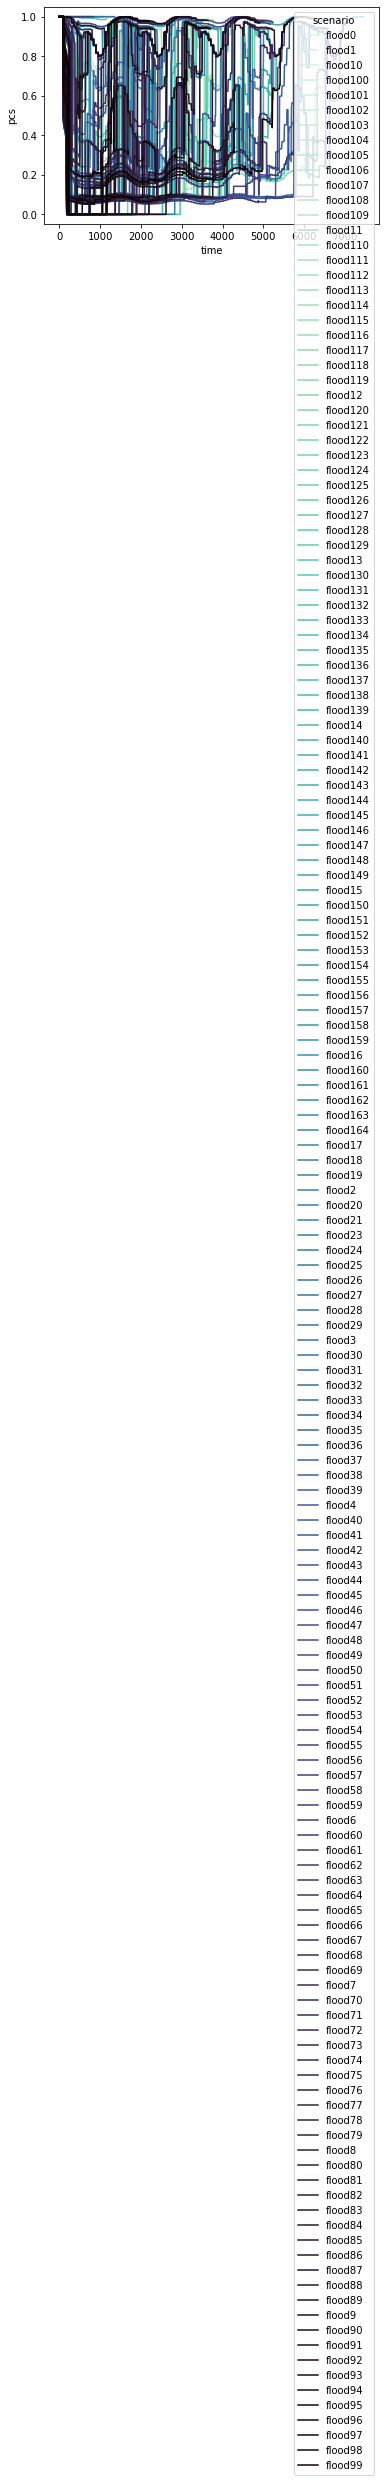

In [15]:
field = 'scenario'
palette = sns.color_palette("mako_r", len(perf_data[field].unique()))
sns.lineplot(x='time', y='pcs', hue=field, palette = palette,
             data=perf_data[perf_data['strategy'] == "zone"])